## Rating Distribution Plot

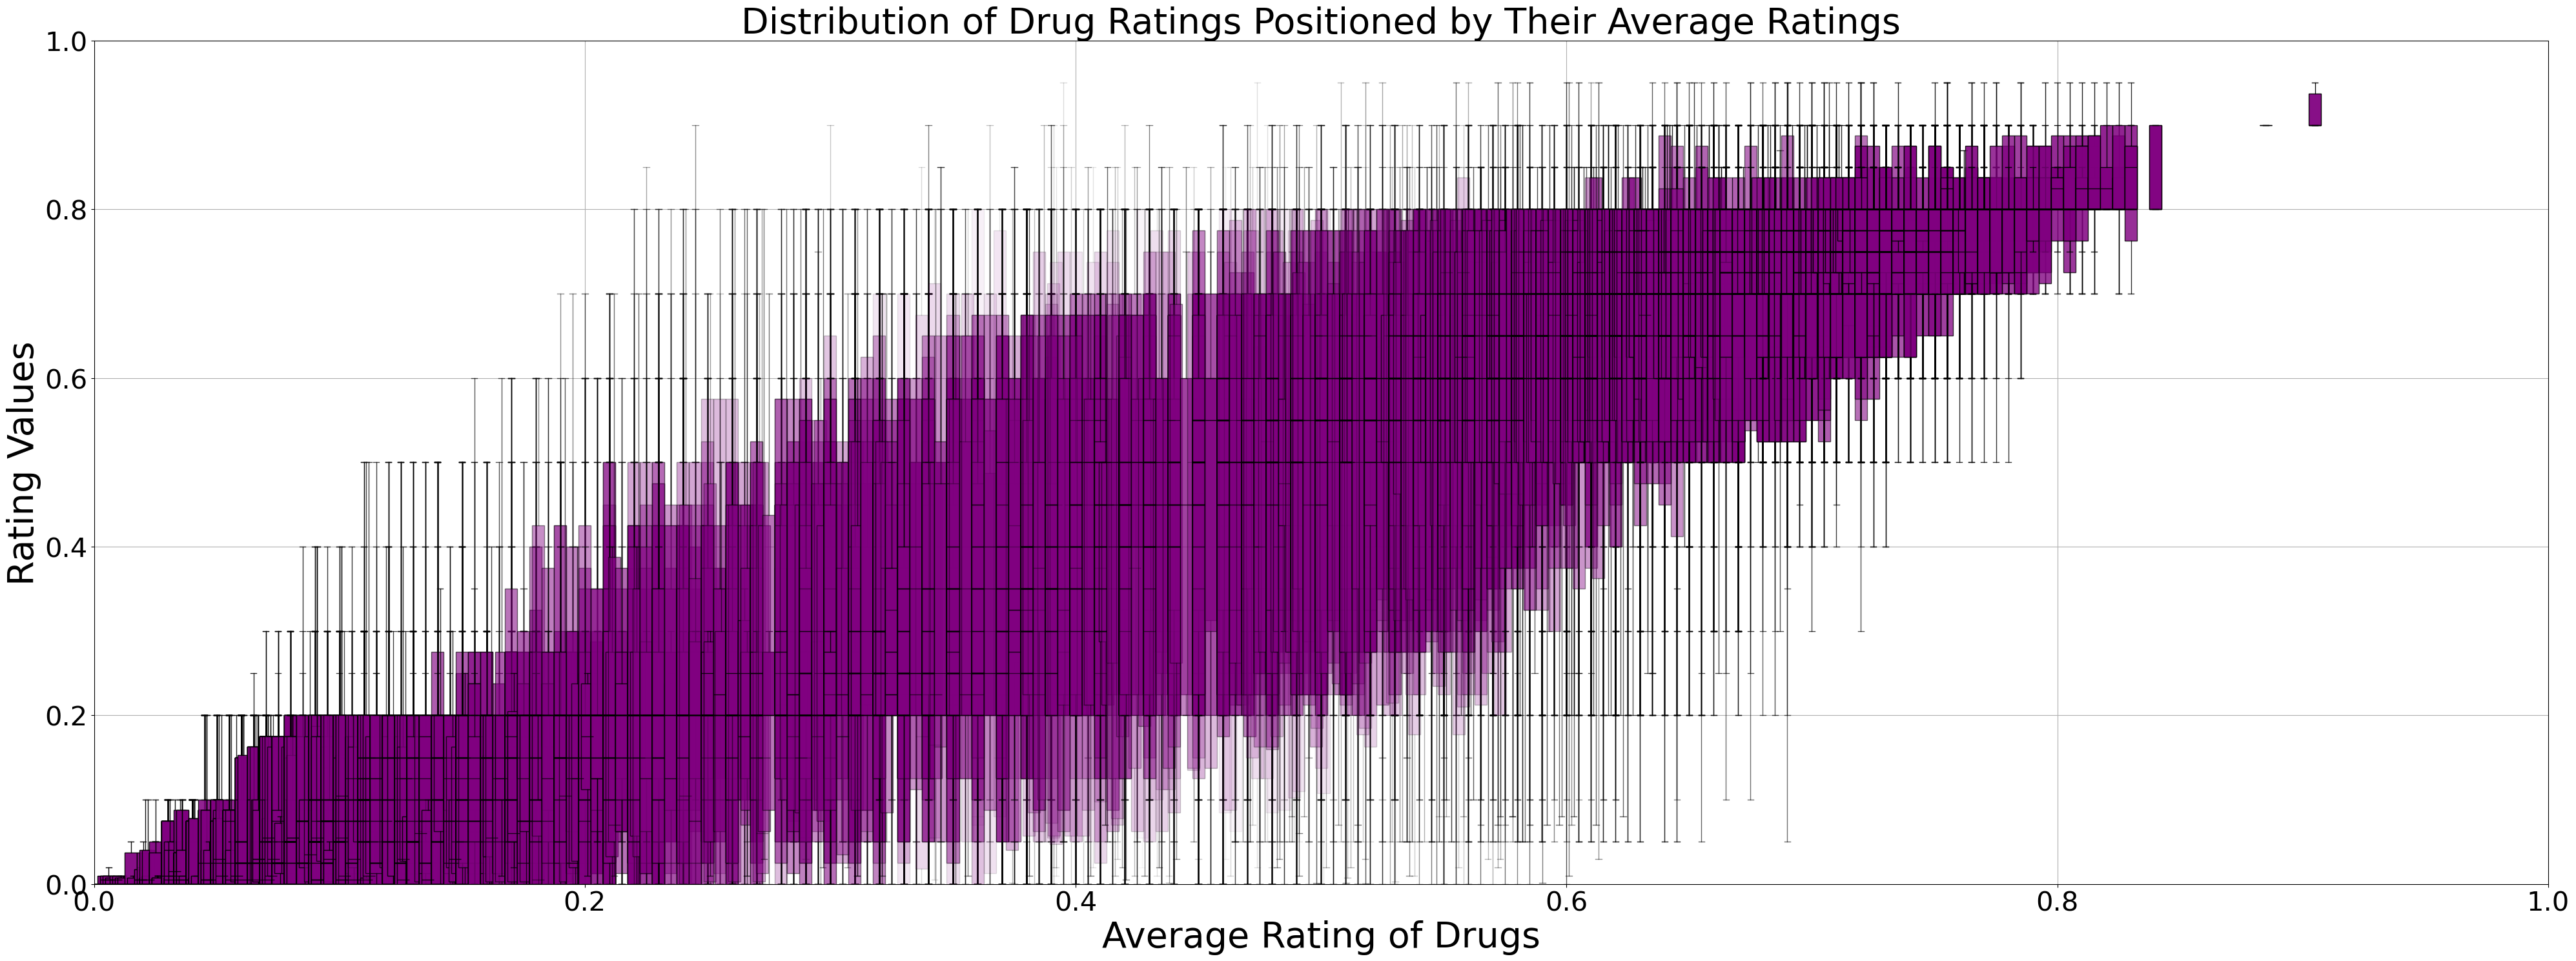

In [25]:
# Rating distribution plot from supplementary material of the paper
import os
from neo4j import GraphDatabase
from dotenv import load_dotenv

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load environment variables from .env file
load_dotenv()

def fetch_ratings(uri, user, password, rating_properties):
    try:
        driver = GraphDatabase.driver(uri, auth=(user, password))
        with driver.session() as session:
            result = session.run(f"""
                MATCH (d:Drug)
                RETURN [{', '.join(['d.' + prop for prop in rating_properties])}] AS ratings
            """)
            drug_ratings = []
            for record in result:
                ratings = record['ratings']
                # Remove None values and ensure ratings are numeric
                ratings = [float(r) for r in ratings if r is not None]
                if ratings:  # Only include drugs that have at least one rating
                    mean_rating = np.mean(ratings)
                    drug_ratings.append({'mean_rating': mean_rating, 'ratings': ratings})
            return drug_ratings
    except Exception as e:
        print(f"Error fetching ratings: {e}")
        return []
    finally:
        if 'driver' in locals():
            driver.close()

def plot_boxplots(drug_ratings):
    # Extract mean ratings and rating lists
    mean_ratings = [drug['mean_rating'] for drug in drug_ratings]
    data = [drug['ratings'] for drug in drug_ratings]

    # Calculate variability (e.g., interquartile range) for each drug's ratings
    variability = []
    for ratings in data:
        if len(ratings) >= 2:
            q1, q3 = np.percentile(ratings, [25, 75])
            iqr = q3 - q1
            variability.append(iqr)
        else:
            variability.append(0)  # No variability if only one rating

    # Normalize variability to [0, 1] range
    variability = np.array(variability)
    max_variability = np.max(variability)
    min_variability = np.min(variability)
    # Avoid division by zero
    if max_variability - min_variability == 0:
        variability_normalized = np.zeros_like(variability)
    else:
        variability_normalized = (variability - min_variability) / (max_variability - min_variability)

    # Map variability to alpha values (higher variability -> lower alpha)
    min_alpha = 0.001  # More transparent
    max_alpha = 0.99  # Less transparent
    alphas = max_alpha - variability_normalized * (max_alpha - min_alpha)

    # Sort the data based on mean ratings
    sorted_indices = np.argsort(mean_ratings)
    mean_ratings = np.array(mean_ratings)[sorted_indices]
    data = [data[i] for i in sorted_indices]
    alphas = alphas[sorted_indices]

    # Set up the plot
    plt.figure(figsize=(40, 15))

    # Plot the boxplots at positions specified by mean ratings
    bplot = plt.boxplot(
        data,
        positions=mean_ratings,
        widths=0.005,  # Slimmer boxplots
        vert=True,
        patch_artist=True,
        showfliers=False,
        manage_ticks=False
    )

    # Customize boxplot appearance
    num_boxes = len(bplot['boxes'])
    for idx in range(num_boxes):
        box = bplot['boxes'][idx]
        whiskers = bplot['whiskers'][2*idx:2*idx+2]  # Each box has two whiskers

        # Set alpha based on variability
        alpha = alphas[idx]

        # Apply to box
        box.set_facecolor('purple')
        box.set_alpha(alpha)
        box.set_edgecolor('black')

        # Apply to whiskers
        for whisker in whiskers:
            whisker.set_color('black')
            whisker.set_alpha(alpha)

        # Apply to caps
        caps = bplot['caps'][2*idx:2*idx+2]
        for cap in caps:
            cap.set_color('black')
            cap.set_alpha(alpha)

        # Apply to medians
        median = bplot['medians'][idx]
        median.set_color('black')
        median.set_alpha(alpha)

    plt.ylim(0, 1)
    plt.xlim(0, 1)

    plt.xlabel('Average Rating of Drugs', fontsize=40)
    plt.ylabel('Rating Values', fontsize=40)
    plt.title('Distribution of Drug Ratings Positioned by Their Average Ratings', fontsize=40)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Connection details
uri = os.getenv("uri")
user = os.getenv("username")
password = os.getenv("password")

# List of rating properties to compare
rating_properties = [f'rating_{i}' for i in range(10)]  # rating_0 to rating_9

# Fetch ratings and plot boxplots
drug_ratings = fetch_ratings(uri, user, password, rating_properties)
if drug_ratings:  # Check if there's any rating data
    plot_boxplots(drug_ratings)


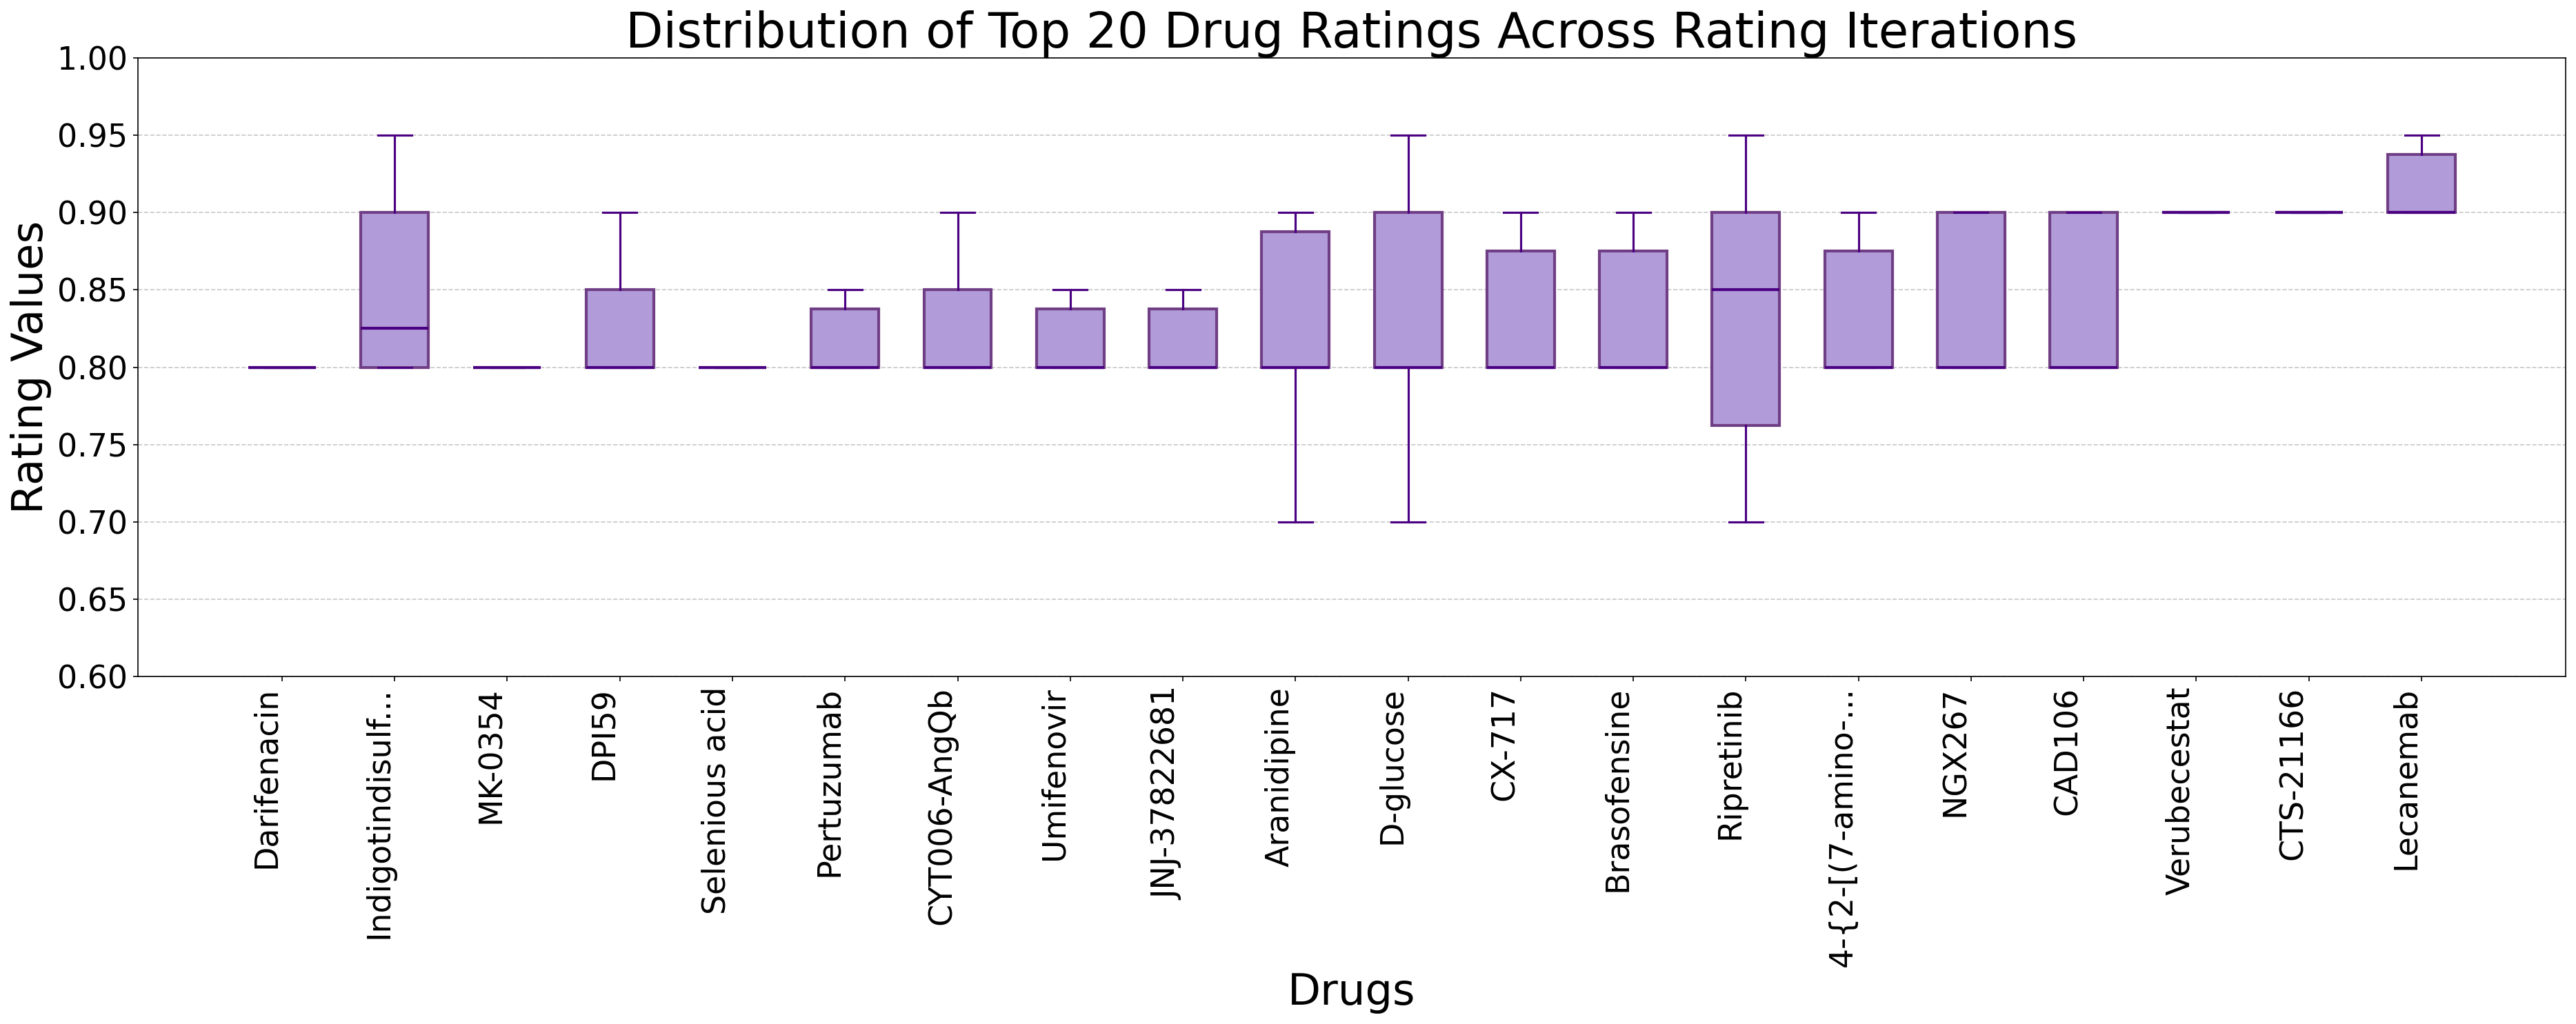

In [36]:
# Rating distribution from main paper
import os
from neo4j import GraphDatabase
from dotenv import load_dotenv

import matplotlib.pyplot as plt
import numpy as np

# Load environment variables from .env file
load_dotenv()

def fetch_ratings(uri, user, password, rating_properties):
    """
    Fetches drug ratings from the Neo4j database and returns the top 20 drugs based on mean ratings.

    :param uri: Neo4j URI
    :param user: Username for Neo4j
    :param password: Password for Neo4j
    :param rating_properties: List of rating property names
    :return: List of dictionaries containing drug names, mean ratings, and ratings
    """
    try:
        driver = GraphDatabase.driver(uri, auth=(user, password))
        with driver.session() as session:
            # Include d.name in the returned properties
            query = f"""
                MATCH (d:Drug)
                RETURN d.name AS name, [{', '.join(['d.' + prop for prop in rating_properties])}] AS ratings
            """
            result = session.run(query)
            drug_ratings = []
            for record in result:
                name = record.get('name', 'Unknown')  # Get the drug name, default to 'Unknown' if missing
                ratings = record['ratings']
                # Remove None values and ensure ratings are numeric
                ratings = [float(r) for r in ratings if r is not None]
                if ratings:  # Only include drugs that have at least one rating
                    mean_rating = np.mean(ratings)
                    drug_ratings.append({'name': name, 'mean_rating': mean_rating, 'ratings': ratings})
    
        # Sort the drugs by mean_rating in ascending order
        drug_ratings_sorted = sorted(drug_ratings, key=lambda x: x['mean_rating'])
    
        # Select top 20 drugs with highest mean ratings
        top_20_drugs = sorted(drug_ratings_sorted, key=lambda x: x['mean_rating'], reverse=True)[:20]
    
        return top_20_drugs
    except Exception as e:
        print(f"Error fetching ratings: {e}")
        return []
    finally:
        if 'driver' in locals():
            driver.close()

def truncate_name(name, char_limit=15):
    """
    Truncates the drug name if it exceeds the specified character limit and appends '...'.

    :param name: Original drug name
    :param char_limit: Maximum number of characters allowed before truncation
    :return: Truncated drug name with '...' if it was longer than the limit
    """
    if len(name) > char_limit:
        return name[:char_limit] + "..."
    return name

def plot_boxplots(drug_ratings, char_limit=15):
    """
    Plots boxplots for the top drugs based on their mean ratings, sorted from low to high.
    Long drug names are truncated to a specified character limit.

    :param drug_ratings: List of dictionaries containing drug data
    :param char_limit: Maximum number of characters for drug names before truncation
    """
    # Extract names, mean ratings, and rating lists
    names = [drug['name'] for drug in drug_ratings]
    mean_ratings = [drug['mean_rating'] for drug in drug_ratings]
    data = [drug['ratings'] for drug in drug_ratings]

    # Sort the data based on mean ratings in ascending order for left-to-right plotting
    sorted_indices = np.argsort(mean_ratings)
    names_sorted = [names[i] for i in sorted_indices]
    data_sorted = [data[i] for i in sorted_indices]
    mean_ratings_sorted = [mean_ratings[i] for i in sorted_indices]

    # Truncate the names that are too long
    truncated_names_sorted = [truncate_name(name, char_limit=char_limit) for name in names_sorted]

    # Assign categorical positions
    x_positions = np.arange(1, len(names_sorted) + 1)

    # Set up the plot with higher DPI for smoother edges
    plt.figure(figsize=(25, 10), dpi=150)  # Increased DPI for better resolution

    # Plot the boxplots
    bplot = plt.boxplot(
        data_sorted,
        positions=x_positions,
        widths=0.6,  # Wider boxplots for categorical spacing
        vert=True,
        patch_artist=True,
        showfliers=False,
        manage_ticks=False
    )

    # Customize boxplot appearance
    for idx in range(len(bplot['boxes'])):
        box = bplot['boxes'][idx]
        whiskers = bplot['whiskers'][2*idx:2*idx+2]  # Each box has two whiskers
        caps = bplot['caps'][2*idx:2*idx+2]
        median = bplot['medians'][idx]

        # Apply to box
        box.set_facecolor('#B19CD9')  # Light purple
        box.set_edgecolor('#703E85')  # Dark purple
        box.set_linewidth(2)  # Thicker edges for smoother appearance

        # Apply to whiskers
        for whisker in whiskers:
            whisker.set_color('#4B0082')  # Dark purple
            whisker.set_linewidth(1.5)  # Thicker whiskers

        # Apply to caps
        for cap in caps:
            cap.set_color('#4B0082')  # Dark purple
            cap.set_linewidth(1.5)  # Thicker caps

        # Apply to medians
        median.set_color('#4B0082')  # Dark purple
        median.set_linewidth(2)  # Thicker median lines

    # Set x-axis labels with truncated names
    plt.xticks(x_positions, truncated_names_sorted, rotation=90, ha='right', fontsize=22)
    plt.yticks(fontsize=22)

    # Set y-axis limit to focus on ratings above 0.6
    plt.ylim(0.6, 1.0)

    # Set labels and title with increased font sizes
    plt.xlabel('Drugs', fontsize=30)
    plt.ylabel('Rating Values', fontsize=30)
    plt.title('Distribution of Top 20 Drug Ratings Across Rating Iterations', fontsize=34)

    # Add grid lines for better readability
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)

    # Enhance layout to prevent clipping of labels
    plt.tight_layout()

    # Display the plot
    plt.show()

# Connection details
uri = os.getenv("uri")
user = os.getenv("username")
password = os.getenv("password")

# List of rating properties to compare
rating_properties = [f'rating_{i}' for i in range(10)]  # rating_0 to rating_9

# Fetch ratings and plot boxplots
drug_ratings = fetch_ratings(uri, user, password, rating_properties)
if drug_ratings:  # Check if there's any rating data
    plot_boxplots(drug_ratings, char_limit=15)  # Set desired character limit here
